In [1]:
import os
import cv2
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras import regularizers
from tensorflow.keras.models import Model, load_model
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
import seaborn as sns
sns.set_style('darkgrid')
from sklearn.metrics import confusion_matrix, classification_report
from IPython.core.display import display, HTML

In [2]:
sdir=r'/kaggle/input/poultry/train'
slist=os.listdir(sdir)
classes=[]
filepaths=[]
labels=[]
for d in slist:
    dpath=os.path.join(sdir, d)
    if os.path.isdir(dpath):
        classes.append(d)
class_count=len(classes)
for klass in classes:
    classpath=os.path.join(sdir,klass)
    filelist=os.listdir(classpath)
    for f in filelist:
        fpath=os.path.join(classpath, f)
        filepaths.append(fpath)
        labels.append(klass)
print ('number of files: ', len(filepaths), '   number of labels: ', len(labels))
file_series=pd.Series(filepaths, name='filepaths')
label_series=pd.Series(labels, name='labels')
df=pd.concat([file_series, label_series], axis=1)
print (df.head())

number of files:  3682    number of labels:  3682
                                           filepaths labels
0  /kaggle/input/poultry/train/salmo/salmo-492_jp...  salmo
1  /kaggle/input/poultry/train/salmo/salmo-422_jp...  salmo
2  /kaggle/input/poultry/train/salmo/salmo-53_jpg...  salmo
3  /kaggle/input/poultry/train/salmo/salmo-260_jp...  salmo
4  /kaggle/input/poultry/train/salmo/salmo-1174_j...  salmo


In [3]:
balance=df['labels'].value_counts()
print (balance)

labels
ncd        949
salmo      938
healthy    906
cocci      889
Name: count, dtype: int64


In [4]:
train_split=.8
test_split=.1
dummy_split=test_split/(1-train_split)
train_df, dummy_df=train_test_split(df, train_size=train_split, shuffle=True, random_state=125)
test_df, valid_df= train_test_split(dummy_df, train_size=dummy_split, shuffle=True, random_state=125)
print ('train size: ', len(train_df), '  test size: ', len(test_df), '   valid size: ', len(valid_df))
length=len(test_df)

train size:  2945   test size:  368    valid size:  369


In [5]:
batch_size=16
def scalar(x):
    return x/127.5-1 # rescales pixels to range -1 to +1
trgen=tf.keras.preprocessing.image.ImageDataGenerator(preprocessing_function=scalar, horizontal_flip=True)
train_gen=trgen.flow_from_dataframe(train_df, x_col='filepaths', y_col='labels', target_size=(224,224), class_mode='categorical',
                                   batch_size=batch_size, shuffle=True, seed=123)
tvgen=tf.keras.preprocessing.image.ImageDataGenerator(preprocessing_function=scalar)
valid_gen=tvgen.flow_from_dataframe(valid_df, x_col='filepaths', y_col='labels', target_size=(224,224), class_mode='categorical',
                                   batch_size=batch_size, shuffle=False)
# determine test generator batch size and steps to go through the test set exactly once for predictions
test_batch_size=sorted([int(length/n) for n in range(1,length+1) if length % n ==0 and length/n<=batch_size],reverse=True)[0]
test_steps=int(length/test_batch_size)
test_gen=tvgen.flow_from_dataframe(test_df, x_col='filepaths', y_col='labels', target_size=(224,224), class_mode='categorical',
                                   batch_size=test_batch_size, shuffle=False)
test_labels=test_gen.labels

Found 2945 validated image filenames belonging to 4 classes.
Found 369 validated image filenames belonging to 4 classes.
Found 368 validated image filenames belonging to 4 classes.


In [6]:
def show_training_samples(gen):
    class_dict=gen.class_indices
    new_dict={}
    # make a new dictionary with keys and values reversed
    for key, value in class_dict.items(): # dictionary is now {numeric class label: string of class_name}
        new_dict[value]=key
    images,labels=next(gen) # get a sample batch from the generator
    plt.figure(figsize=(15, 18)) # Adjusted figure size for better display
    length=len(labels)
    if length<30:   #show maximum of 30 images
        r=length
    else:
        r=30
    for i in range(r):
        plt.subplot(6, 5, i + 1) # Changed grid to 6x5 to accommodate 30 subplots
        image=(images[i]+1 )/2 # scale images between 0 and 1 becaue pre-processor set them between -1 and +1
        plt.imshow(image)
        index=np.argmax(labels[i])
        class_name=new_dict[index]
        plt.title(class_name, color='blue', fontsize=16)
        plt.axis('off')
    plt.show()

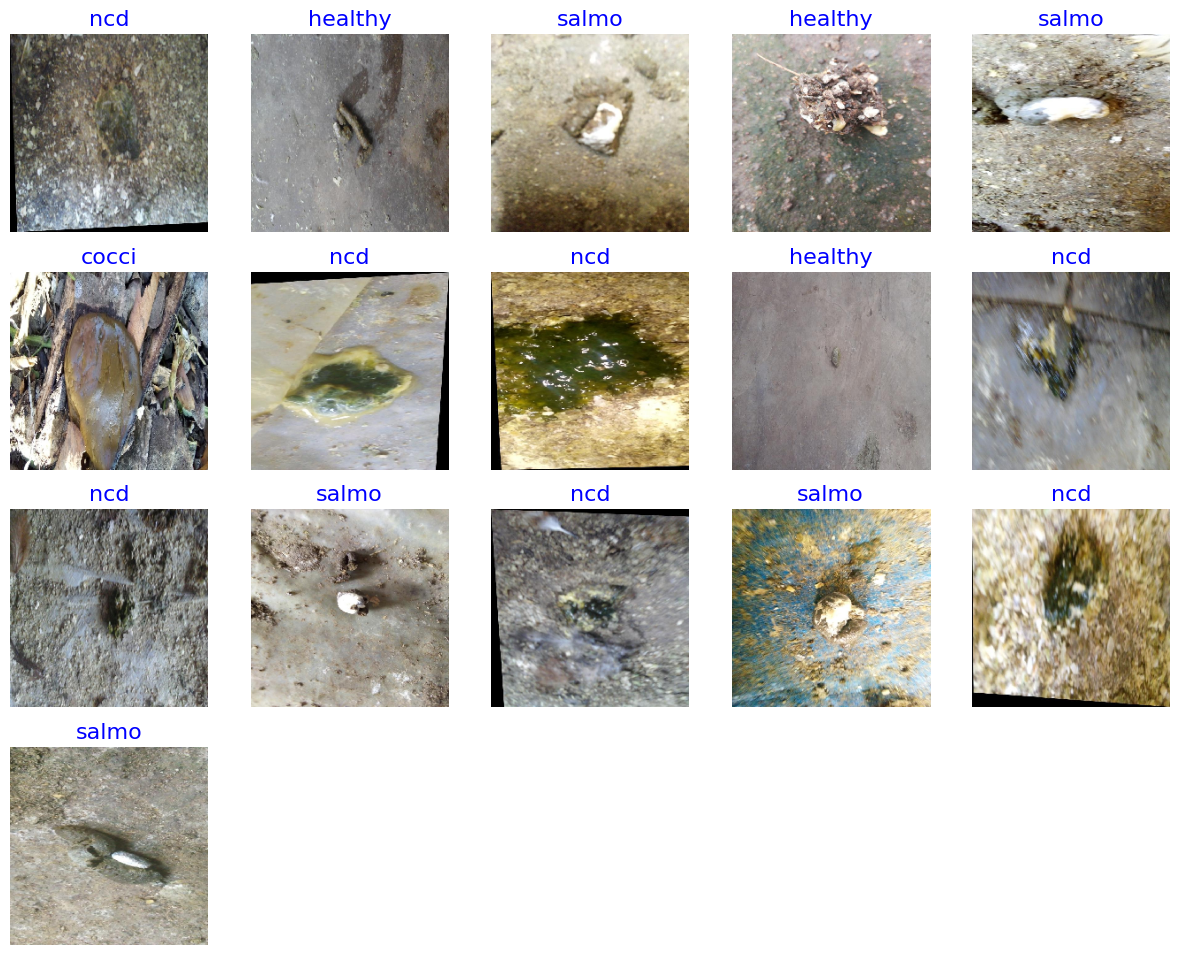

In [7]:
show_training_samples(train_gen)

In [8]:
# Import necessary libraries
from tensorflow.keras import layers, models
from tensorflow.keras.applications import DenseNet169
from tensorflow.keras.optimizers import Adam

# Example: Define input shape
input_shape = (224, 224, 3)  # You can change this if needed, e.g., (299, 299, 3) for InceptionV3 or (160, 160, 3) for MobileNet
class_count = 4  # Replace with the number of classes in your dataset

# Step 1: Load DenseNet121 model with pre-trained ImageNet weights (freeze initial layers)
base_model = DenseNet169(weights='imagenet', include_top=False, input_shape=input_shape)

# Step 2: Define the model architecture
base_model.trainable = False  # Freeze the base model layers to prevent updates during initial training

inputs = layers.Input(shape=input_shape)  # Define the input layer
x = base_model(inputs, training=False)  # Pass input through the base model (with weights frozen)

# Add a Global Average Pooling layer to reduce the output dimensions
x = layers.GlobalAveragePooling2D()(x)

# Add a Dense layer with softmax activation for multi-class classification
outputs = layers.Dense(class_count, activation='softmax')(x)

# Create the final model
model = models.Model(inputs, outputs)

# Step 3: Compile the model for the initial training phase
# We use a small learning rate for the new fully connected layers
model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

# Step 4: Print the model summary before initial training
print("Model Summary before initial training:")
model.summary()

# Initial training (example)
# Replace `train_data` and `val_data` with your actual training and validation datasets
# model.fit(train_data, epochs=5, validation_data=val_data)  # Training for initial 5 epochs

### FINE-TUNING STAGE ###
# Step 5: Fine-tuning - Unfreeze some layers of DenseNet121
# Unfreeze the top layers of the base model (You can choose to unfreeze more or fewer layers)
base_model.trainable = True  # Unfreeze all layers of the base model

# Optionally, you can freeze the first few layers to avoid overfitting and unfreeze the later layers.
# For example, freeze the first 100 layers and unfreeze the rest.
# This is a common strategy to prevent disrupting the general feature extraction in early layers.
# Feel free to change the number of layers to freeze based on your needs.
for layer in base_model.layers[:100]:  # Freezing the first 100 layers
    layer.trainable = False

# Step 6: Recompile the model with a lower learning rate for fine-tuning
# Use a very small learning rate (e.g., 1e-5 or 1e-6) during fine-tuning to avoid forgetting the pre-trained features
model.compile(optimizer=Adam(learning_rate=0.00001), loss='categorical_crossentropy', metrics=['accuracy'])

# Step 7: Print the model summary after fine-tuning setup
print("\nModel Summary after fine-tuning:")
model.summary()

# Fine-tuning phase (example)
# Replace `train_data` and `val_data` with your actual training and validation datasets
# You can train for more epochs since you've now unfreezed some layers of the model.
# Fine-tuning typically requires fewer epochs compared to initial training (e.g., 10-20 epochs).
# model.fit(train_data, epochs=10, validation_data=val_data)  # Fine-tuning for additional 10 epochs


51877672/51877672 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Model Summary before initial training:


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)           │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ densenet169 (Functional)             │ (None, 7, 7, 1664)          │      12,642,880 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 1664)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 4)                   │           6,660 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 12,649,540 (48.25 MB)

 Trainable params: 6,660 (26.02 KB)

 Non-trainable params: 12,642,880 (48.23 MB)


Model Summary after fine-tuning:


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)           │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ densenet169 (Functional)             │ (None, 7, 7, 1664)          │      12,642,880 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 1664)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 4)                   │           6,660 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 12,649,540 (48.25 MB)

 Trainable params: 11,686,468 (44.58 MB)

 Non-trainable params: 963,072 (3.67 MB)

In [9]:
history = model.fit(train_gen, validation_data=valid_gen, epochs=10, verbose=1)

Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


185/185 ━━━━━━━━━━━━━━━━━━━━ 353s 888ms/step - accuracy: 0.5996 - loss: 0.9934 - val_accuracy: 0.9214 - val_loss: 0.2580
Epoch 2/10
185/185 ━━━━━━━━━━━━━━━━━━━━ 27s 145ms/step - accuracy: 0.9475 - loss: 0.2054 - val_accuracy: 0.9729 - val_loss: 0.1247
Epoch 3/10
185/185 ━━━━━━━━━━━━━━━━━━━━ 28s 148ms/step - accuracy: 0.9710 - loss: 0.1247 - val_accuracy: 0.9837 - val_loss: 0.0874
Epoch 4/10
185/185 ━━━━━━━━━━━━━━━━━━━━ 28s 151ms/step - accuracy: 0.9845 - loss: 0.0737 - val_accuracy: 0.9837 - val_loss: 0.0761
Epoch 5/10
185/185 ━━━━━━━━━━━━━━━━━━━━ 29s 151ms/step - accuracy: 0.9897 - loss: 0.0542 - val_accuracy: 0.9837 - val_loss: 0.0634
Epoch 6/10
185/185 ━━━━━━━━━━━━━━━━━━━━ 28s 150ms/step - accuracy: 0.9892 - loss: 0.0457 - val_accuracy: 0.9810 - val_loss: 0.0601
Epoch 7/10
185/185 ━━━━━━━━━━━━━━━━━━━━ 28s 149ms/step - accuracy: 0.9931 - loss: 0.0399 - val_accuracy: 0.9864 - val_loss: 0.0562
Epoch 8/10
185/185 ━━━━━━━━━━━━━━━━━━━━ 28s 149ms/step - accuracy: 0.9959 - loss: 0.0282 - va

In [10]:
def tr_plot(tr_data, start_epoch):
    #Plot the training and validation data
    tacc=tr_data.history['accuracy']
    tloss=tr_data.history['loss']
    vacc=tr_data.history['val_accuracy']
    vloss=tr_data.history['val_loss']
    Epoch_count=len(tacc)+ start_epoch
    Epochs=[]
    for i in range (start_epoch ,Epoch_count):
        Epochs.append(i+1)
    index_loss=np.argmin(vloss)#  this is the epoch with the lowest validation loss
    val_lowest=vloss[index_loss]
    index_acc=np.argmax(vacc)
    acc_highest=vacc[index_acc]
    plt.style.use('fivethirtyeight')
    sc_label='best epoch= '+ str(index_loss+1 +start_epoch)
    vc_label='best epoch= '+ str(index_acc + 1+ start_epoch)
    fig,axes=plt.subplots(nrows=1, ncols=2, figsize=(20,8))
    axes[0].plot(Epochs,tloss, 'r', label='Training loss')
    axes[0].plot(Epochs,vloss,'g',label='Validation loss' )
    axes[0].scatter(index_loss+1 +start_epoch,val_lowest, s=150, c= 'blue', label=sc_label)
    axes[0].set_title('Training and Validation Loss')
    axes[0].set_xlabel('Epochs')
    axes[0].set_ylabel('Loss')
    axes[0].legend()
    axes[1].plot (Epochs,tacc,'r',label= 'Training Accuracy')
    axes[1].plot (Epochs,vacc,'g',label= 'Validation Accuracy')
    axes[1].scatter(index_acc+1 +start_epoch,acc_highest, s=150, c= 'blue', label=vc_label)
    axes[1].set_title('Training and Validation Accuracy')
    axes[1].set_xlabel('Epochs')
    axes[1].set_ylabel('Accuracy')
    axes[1].legend()
    plt.tight_layout
    #plt.style.use('fivethirtyeight')
    plt.show()

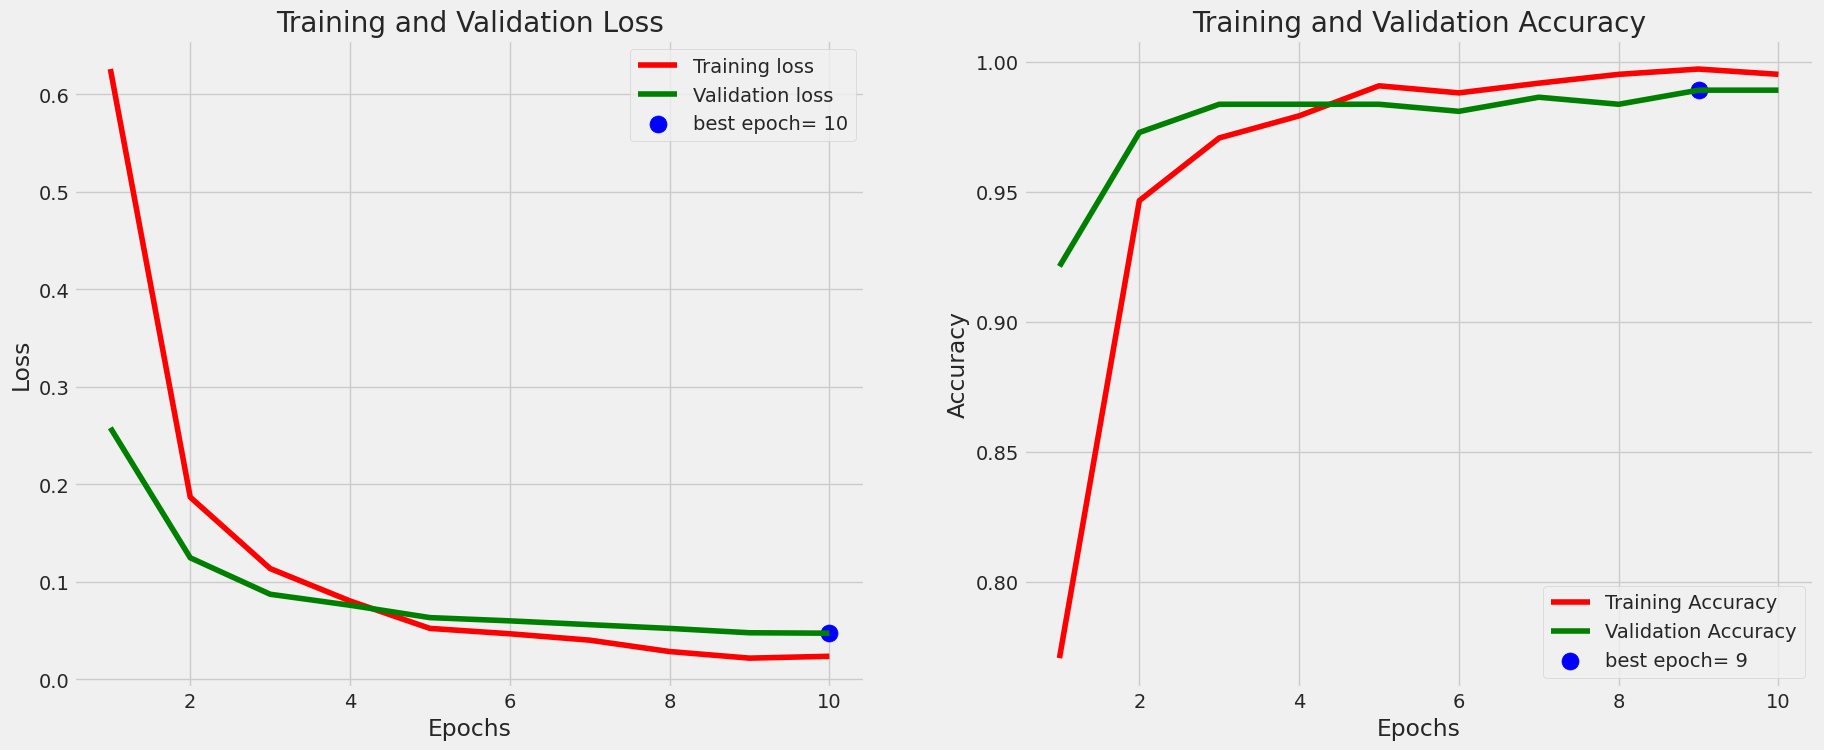

In [11]:
tr_plot(history, 0)

/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


23/23 ━━━━━━━━━━━━━━━━━━━━ 13s 115ms/step
Confusion Matrix
[[ 94   0   0   1]
 [  0 102   1   0]
 [  0   1  77   0]
 [  1   2   0  89]]
Classification Report
              precision    recall  f1-score   support

       cocci       0.99      0.99      0.99        95
     healthy       0.97      0.99      0.98       103
         ncd       0.99      0.99      0.99        78
       salmo       0.99      0.97      0.98        92

    accuracy                           0.98       368
   macro avg       0.98      0.98      0.98       368
weighted avg       0.98      0.98      0.98       368



RuntimeError: No mappable was found to use for colorbar creation. First define a mappable such as an image (with imshow) or a contour set (with contourf).

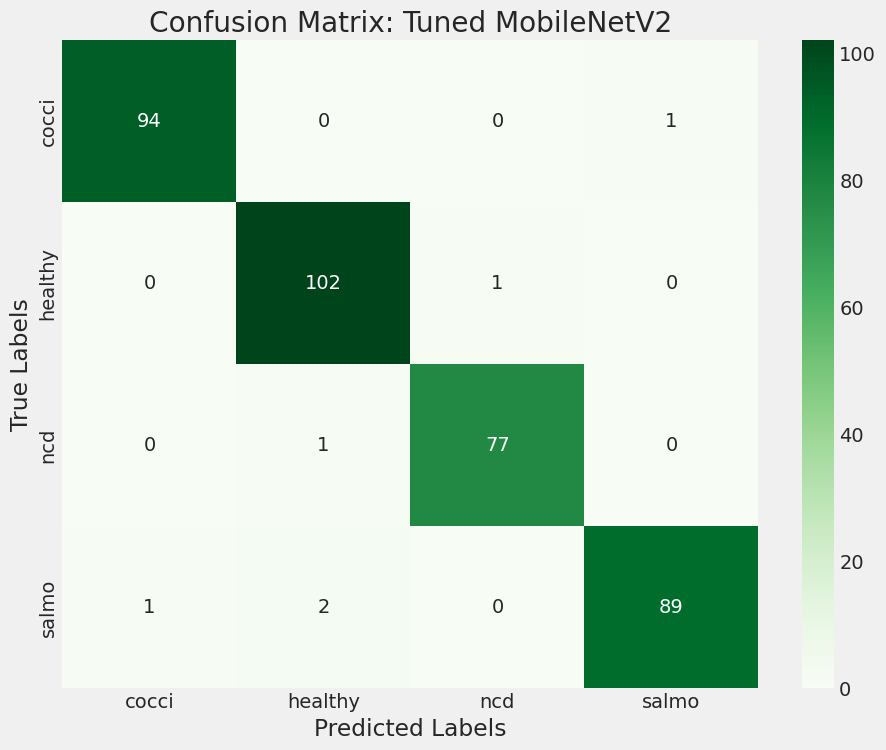

In [12]:
preds = model.predict(test_gen, verbose=1)
y_pred = np.argmax(preds, axis=1)
class_names = list(test_gen.class_indices.keys())
print('Confusion Matrix')
cm = confusion_matrix(test_labels, y_pred)
print(cm)

print('Classification Report')
print(classification_report(test_labels, y_pred, target_names=class_names))

# Plot the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Greens', xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix: Tuned MobileNetV2')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.colorbar(label='Count')
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


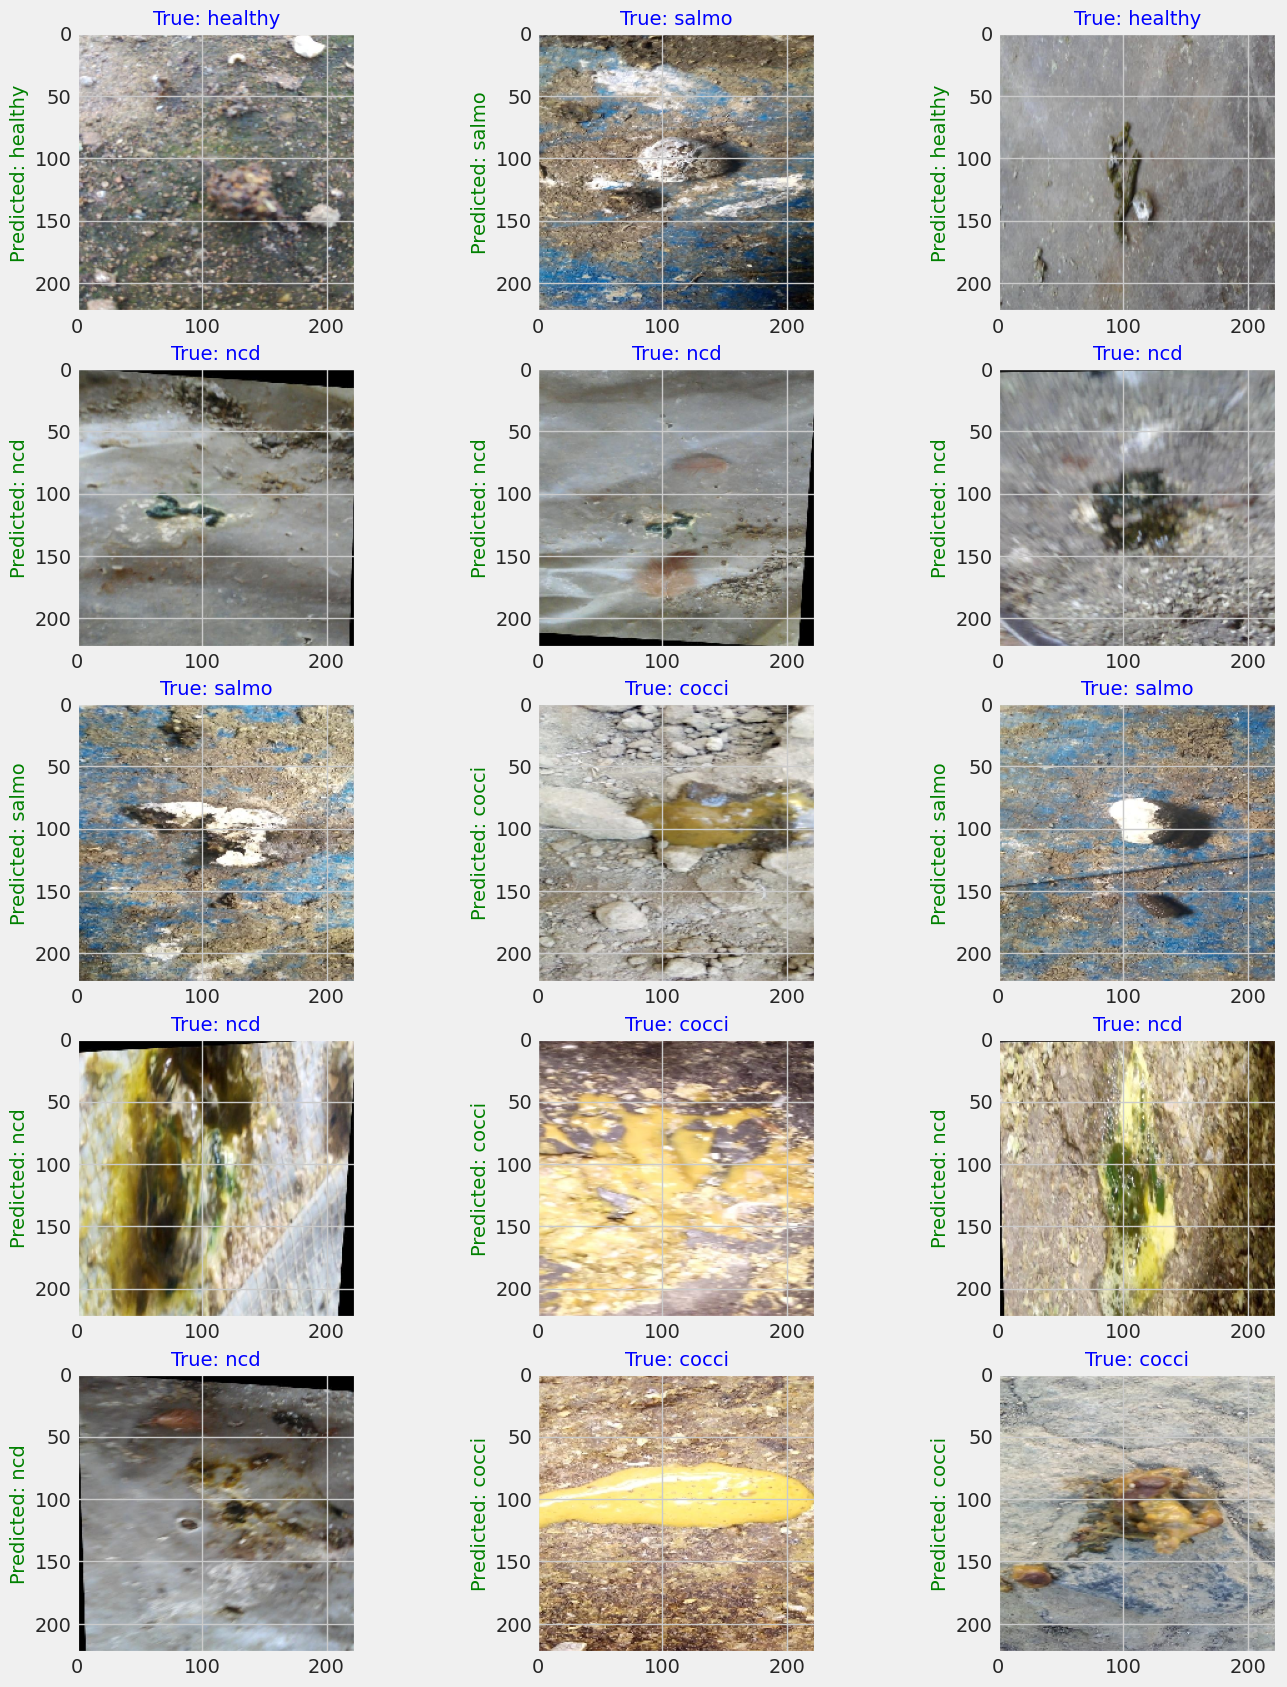

In [13]:
def print_images(gen):
    class_dict = gen.class_indices
    new_dict = {}
    # make a new dictionary with keys and values reversed
    for key, value in class_dict.items():
        new_dict[value] = key
    images, labels = next(gen)
    plt.figure(figsize=(15, 20))
    length = len(labels)
    if length < 15:
        r = length
    else:
        r = 15
    for i in range(r):
        plt.subplot(5, 3, i + 1)
        image = (images[i] + 1) / 2
        plt.imshow(image)
        index = np.argmax(labels[i])
        class_name = new_dict[index]
        pred = model.predict(np.expand_dims(images[i], axis=0))
        pred_index = np.argmax(pred)
        pred_class_name = new_dict[pred_index]
        plt.title(f"True: {class_name}", color='blue', fontsize=14) # Set true class title color to blue
        plt.ylabel(f"Predicted: {pred_class_name}", color='green', fontsize=14) # Set predicted class title color to green and moved it to xlabel for better visibility
        plt.axis('on')
    plt.show()

print_images(train_gen)

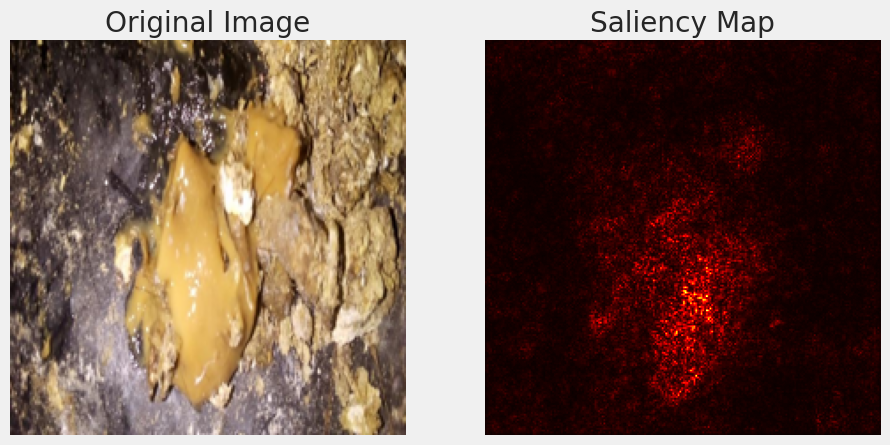

In [22]:
import torch
import torch.nn as nn
import torchvision.models as models
import torchvision.transforms as transforms
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

# Load pre-trained model
model = models.vgg16(pretrained=True)
model.eval()

# Image preprocessing
def preprocess_image(image_path):
    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                           std=[0.229, 0.224, 0.225])
    ])
    
    image = Image.open(image_path).convert('RGB')
    image_tensor = transform(image).unsqueeze(0)
    return image_tensor

# Function to compute saliency map
def compute_saliency_map(model, image_tensor):
    # Set requires_grad to True to compute gradients
    image_tensor.requires_grad_()
    
    # Forward pass
    output = model(image_tensor)
    score_max_index = output.argmax(dim=1)
    score_max = output[0, score_max_index]
    
    # Backward pass to get gradients
    score_max.backward()
    
    # Get the gradients and compute saliency
    gradients = image_tensor.grad.data
    saliency, _ = torch.max(gradients.abs(), dim=1)
    saliency = saliency.squeeze().cpu().numpy()
    
    return saliency

# Function to visualize results
def visualize_saliency(image_path, saliency):
    # Load original image
    original_image = Image.open(image_path).convert('RGB')
    original_image = original_image.resize((224, 224))
    
    # Plot original image and saliency map
    plt.figure(figsize=(10, 5))
    
    plt.subplot(1, 2, 1)
    plt.imshow(original_image)
    plt.title('Original Image')
    plt.axis('off')
    
    plt.subplot(1, 2, 2)
    plt.imshow(saliency, cmap='hot')
    plt.title('Saliency Map')
    plt.axis('off')
    
    plt.show()

# Main execution
def main(image_path):
    # Preprocess the image
    image_tensor = preprocess_image(image_path)
    
    # Compute saliency map
    saliency = compute_saliency_map(model, image_tensor)
    
    # Visualize results
    visualize_saliency(image_path, saliency)

if __name__ == "__main__":
    # Replace with your image path
    image_path = "/kaggle/input/poultry/train/cocci/cocci-1016_jpg.rf.26dc6cbd8af06cfd72bbca2c569422c1.jpg"
    main(image_path)

In [23]:
pip install scipy

Note: you may need to restart the kernel to use updated packages.


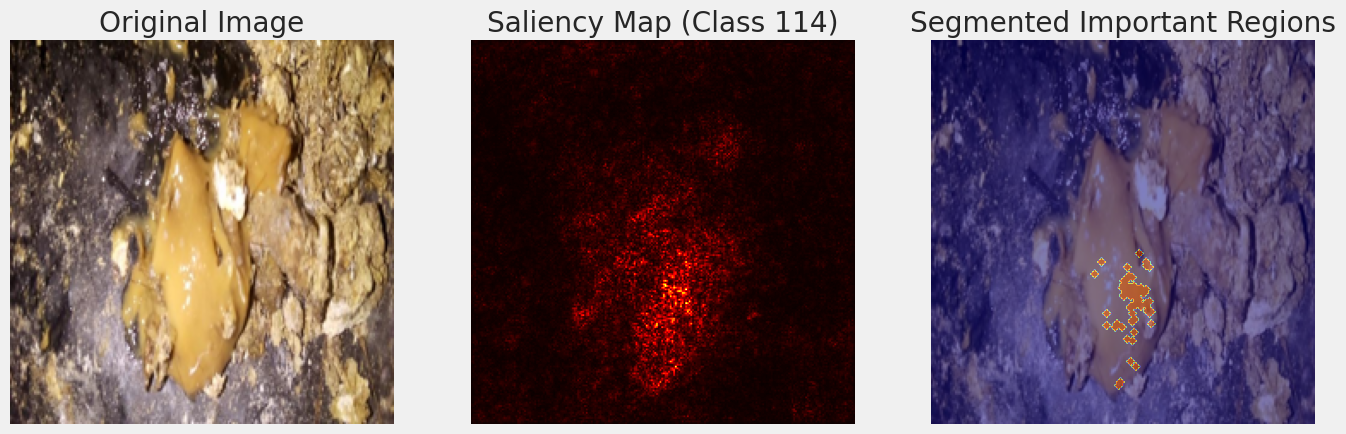

In [24]:
import torch
import torch.nn as nn
import torchvision.models as models
import torchvision.transforms as transforms
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

# Load pre-trained model
model = models.vgg16(pretrained=True)
model.eval()

# Image preprocessing
def preprocess_image(image_path):
    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                           std=[0.229, 0.224, 0.225])
    ])
    
    image = Image.open(image_path).convert('RGB')
    image_tensor = transform(image).unsqueeze(0)
    return image_tensor

# Function to compute class-specific saliency map
def compute_class_saliency_map(model, image_tensor, target_class=None):
    image_tensor.requires_grad_()
    
    # Forward pass
    output = model(image_tensor)
    
    if target_class is None:
        target_class = output.argmax(dim=1).item()
    
    # Zero out gradients
    model.zero_grad()
    
    # Backward pass for specific class
    one_hot = torch.zeros_like(output)
    one_hot[0, target_class] = 1
    output.backward(gradient=one_hot)
    
    # Get gradients and compute saliency
    gradients = image_tensor.grad.data
    saliency, _ = torch.max(gradients.abs(), dim=1)
    saliency = saliency.squeeze().cpu().numpy()
    
    return saliency, target_class

# Function to segment important regions
def segment_important_regions(saliency, threshold=0.5):
    # Normalize saliency to [0, 1]
    saliency = (saliency - saliency.min()) / (saliency.max() - saliency.min())
    
    # Create binary mask
    mask = (saliency > threshold).astype(np.uint8)
    
    # Optional: Apply morphological operations to clean up the mask
    from scipy.ndimage import binary_dilation
    mask = binary_dilation(mask, iterations=2)
    
    return mask

# Function to visualize results
def visualize_results(image_path, saliency, mask, target_class):
    original_image = Image.open(image_path).convert('RGB')
    original_image = original_image.resize((224, 224))
    
    plt.figure(figsize=(15, 5))
    
    plt.subplot(1, 3, 1)
    plt.imshow(original_image)
    plt.title('Original Image')
    plt.axis('off')
    
    plt.subplot(1, 3, 2)
    plt.imshow(saliency, cmap='hot')
    plt.title(f'Saliency Map (Class {target_class})')
    plt.axis('off')
    
    plt.subplot(1, 3, 3)
    plt.imshow(original_image)
    plt.imshow(mask, alpha=0.5, cmap='jet')
    plt.title('Segmented Important Regions')
    plt.axis('off')
    
    plt.show()

# Main execution
def main(image_path, target_class=None):
    # Preprocess the image
    image_tensor = preprocess_image(image_path)
    
    # Compute saliency map for specific class
    saliency, target_class = compute_class_saliency_map(model, image_tensor, target_class)
    
    # Segment important regions
    mask = segment_important_regions(saliency)
    
    # Visualize results
    visualize_results(image_path, saliency, mask, target_class)

if __name__ == "__main__":
    # Replace with your image path
    image_path = "/kaggle/input/poultry/train/cocci/cocci-1016_jpg.rf.26dc6cbd8af06cfd72bbca2c569422c1.jpg"
    
    # Optional: Specify a target class (e.g., 281 for 'tabby cat' in ImageNet)
    # If None, uses the predicted class
    target_class = None  # or specify an ImageNet class ID
    
    main(image_path, target_class)

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from lime import lime_image
from skimage.segmentation import mark_boundaries
import random

# Define the prediction function for LIME (which matches your model setup)
def predict_fn(images):
    images = np.array(images)  # Convert list of images to a numpy array
    images = (images / 127.5) - 1  # Rescale the images to [-1, 1]
    return model.predict(images)  # Return predictions from the model

# Initialize LIME explainer
explainer = lime_image.LimeImageExplainer()

# Number of images to process
num_images_to_process = 5

# Get 5 random indices from the dataset
random_indices = random.sample(range(len(test_gen)), num_images_to_process)

# Set up the subplot grid (5 rows, 2 columns)
fig, axes = plt.subplots(num_images_to_process, 2, figsize=(10, 4 * num_images_to_process))

# Loop through random indices and process images
for i, idx in enumerate(random_indices):
    test_image_batch, true_label_batch = test_gen[idx]  # Fetch the batch
    test_image = test_image_batch[0]  # Use the first image in the batch
    true_label = np.argmax(true_label_batch[0])  # Convert one-hot to index
    
    # Get model predictions for this image
    predicted_probs = model.predict(np.expand_dims(test_image, axis=0))[0]  # Model prediction for the image
    predicted_label = np.argmax(predicted_probs)  # Predicted class label
    
    # Generate LIME explanation for the current image
    explanation = explainer.explain_instance(
        test_image.astype('double'),  # Ensure the image is in double precision
        predict_fn,                   # The function that makes predictions
        top_labels=1,                 # Only get explanation for the top class
        hide_color=0,                 # Color for hidden segments
        num_samples=500               # Number of perturbed samples
    )
    
    # Get the top label(s) from the explanation
    top_labels = explanation.top_labels  # Get the top labels from LIME's explanation
    
    # Ensure the predicted label is in top_labels, or use the first available one
    if predicted_label not in top_labels:
        predicted_label = top_labels[0]

    # Get the image and mask for the predicted label
    temp, mask = explanation.get_image_and_mask(
        label=predicted_label,        # Explanation for the predicted class
        positive_only=True,           # Focus on positive contributions
        num_features=10,              # Number of superpixels
        hide_rest=False               # Show all regions with boundaries
    )
    
    # Display the original image in the first column
    axes[i, 0].imshow((test_image + 1) / 2)  # Rescale to [0, 1] for display
    axes[i, 0].set_title(f"True: {true_label}, Pred: {predicted_label}")
    axes[i, 0].axis('off')
    
    # Display the LIME explanation in the second column
    axes[i, 1].imshow(mark_boundaries(temp.astype('uint8') if temp.max() > 1 else temp, mask))
    axes[i, 1].set_title("LIME Explanation")
    axes[i, 1].axis('off')

# Adjust layout to prevent overlap
plt.tight_layout()

# Save the figure
plt.savefig('/kaggle/working/lime_explanation.png', dpi=300, bbox_inches='tight')

# Show the plot
plt.show()